In [219]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.precision", 2)
df = pd.read_csv('ChessOdds\Database\games_clean.csv')
df.dropna(inplace = True)
print(df.shape)

(15932, 13)


In [220]:
df.head()

,turns,victory_status,result,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,rating_diff
0,4.0,outoftime,0.0,15+15,rustam9,945.0,b3nszy,1070.0,e4 e5 Nf3 Bd6,C40,King's Knight Opening,3.0,-125.0
1,4.0,resign,0.0,15+15,skipskipskop,914.0,hill_j,1141.0,a4 e5 Ra3 Bxa3,A00,Ware Opening,1.0,-227.0
2,4.0,resign,1.0,8+0,w-j,1758.0,slon-al,1804.0,d4 Nf6 c4 e5,A51,Indian Game: Budapest Defense,4.0,-46.0
3,4.0,resign,0.0,30+0,mccheese,1026.0,bratt,1121.0,d4 d5 f3 e6,D00,Queen's Pawn Game,2.0,-95.0
4,4.0,resign,1.0,6+4,ruben11131,1804.0,chess_bros123,1372.0,e4 e5 Nf3 Nc6,C44,King's Knight Opening: Normal Variation,4.0,432.0


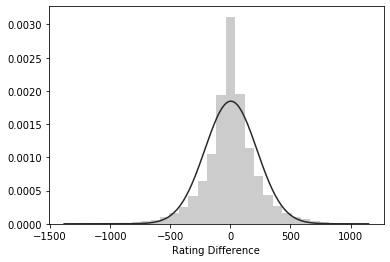

In [204]:
from scipy.stats import norm
sns.distplot(df['rating_diff'], axlabel = 'Rating Difference', fit = norm, bins = 30, kde = False, color = 'gray')

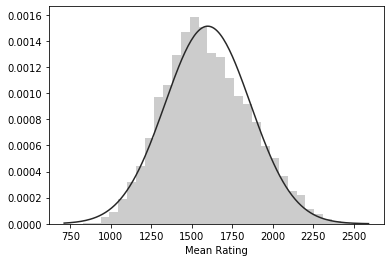

In [225]:
df['mean_rating'] = (df['white_rating'] + df['black_rating'])/2
sns.distplot(df['mean_rating'], axlabel = 'Mean Rating', fit = norm, bins = 30, kde = False, color = 'gray')

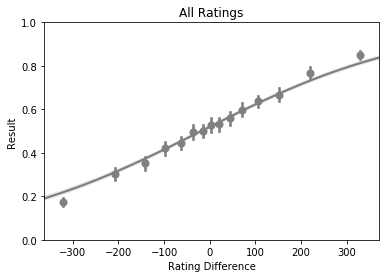

In [274]:
ax = sns.regplot(data = df, x = 'rating_diff', y = 'result', color = 'grey', x_bins = 15, logistic = True)
ax.set(xlabel='Rating Difference', ylabel='Result', title = 'All Ratings')
ax.set_ylim([0,1])
plt.show()

In [226]:
df_high = df.loc[df['mean_rating'] >= 1800]
df_high.head()

,turns,victory_status,result,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,rating_diff,mean_rating
5,4.0,resign,0.0,7+4,chessmaster987,1996.0,gmanderson,2193.0,f4 d5 Nf3 Nf6,A03,Bird Opening: Dutch Variation,2.0,-197.0,2094.5
15,4.0,outoftime,0.0,0+16,yht,2104.0,masterbigsuff,2081.0,e4 d5 f4 e6,A03,Bird Opening: Williams Gambit,3.0,23.0,2092.5
38,5.0,resign,1.0,8+0,chessbuzz17,2141.0,andrei70ster,2180.0,d4 g6 Bh6 Bg7 Bxg7,A40,Modern Defense,2.0,-39.0,2160.5
43,5.0,outoftime,1.0,150+0,omid27,2151.0,dr-muscle,1717.0,d4 d5 c4 Nf6 cxd5,D06,Queen's Gambit Refused: Marshall Defense,4.0,434.0,1934.0
54,6.0,resign,0.0,10+0,apicots,1500.0,babychess3,2113.0,e4 c5 Nf3 Nc6 Nc3 d6,B30,Sicilian Defense: Old Sicilian,4.0,-613.0,1806.5


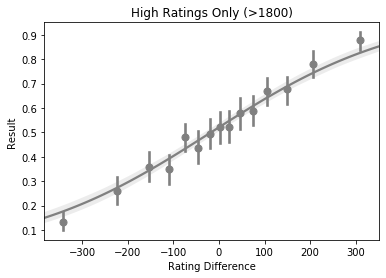

In [228]:
ax = sns.regplot(data = df_high, x = 'rating_diff', y = 'result', color = 'grey', x_bins = 15, logistic = True)
ax.set(xlabel='Rating Difference', ylabel='Result', title = 'High Ratings Only (>1800)')
ax.set_ylim([0,1])
plt.show()

In [86]:
import statsmodels.api as sm

X = df['rating_diff']
y = df['result']

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.619089
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.106     
Dependent Variable: result           AIC:              19728.6463
Date:               2021-01-21 13:14 BIC:              19736.3223
No. Observations:   15932            Log-Likelihood:   -9863.3   
Df Model:           0                LL-Null:          -11029.   
Df Residuals:       15931            LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
                 Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
rating_diff      0.0042    0.0001  41.0222  0.0000  0.0040  0.0044



In [279]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import mord as mrd

x = df['rating_diff'].values
y = df['result'].values

#converts y from 0, 0.5 and 1 to 0, 1 and 2 as mord.LogisticIT only takes integer values
y = y*2
y = y.astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)

ord_model = mrd.LogisticIT().fit(x_train, y_train)
y_pred_ord = ord_model.predict(x_test)
ord_accuracy = ord_model.score(x_test, y_test)
ord_cfm = confusion_matrix(y_test, y_pred_ord)

cat_model = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial').fit(x_train, y_train)
y_pred_cat = cat_model.predict(x_test)
cat_accuracy = cat_model.score(x_test, y_test)
cat_cfm = confusion_matrix(y_test, y_pred_cat)

print('Accuracy of ordinal logistic regression classifier on test set: {:.2f}%  \n'.format(ord_accuracy*100))
print(ord_cfm)
print('\n Accuracy of categorical logistic regression classifier on test set: {:.2f}% \n'.format(cat_accuracy*100))
print(cat_cfm)

Accuracy of ordinal logistic regression classifier on test set: 62.41%  

[[ 837    0  622]
 [  65    0   74]
 [ 437    0 1152]]

 Accuracy of categorical logistic regression classifier on test set: 62.38% 

[[ 841    0  618]
 [  65    0   74]
 [ 442    0 1147]]


In [281]:
diff = -20.20734
diff = np.array([diff]).reshape(1,-1)
result = ord_model.predict_proba(diff)
result = result[0]
white_win_prob = result[2]*100

if 0 <= white_win_prob < 33.33:
    result = 'black'
elif 33.33 <= white_win_prob < 66.67:
    result = 'draw'
elif 66.67 <= white_win_prob <= 100:
    result = 'white'
else:
    result = 'error'
    
print(f'result: {result} \n'
    f'white win probability: {white_win_prob :.2f} %')

result: draw 
white win probability: 50.00 %
